In [1]:
# torchvision.models.video.mc3_18(pretrained=False, progress=True, **kwargs)
import datetime
import os
import time
import torch
import torch.utils.data
from torch.utils.data.dataloader import default_collate
from torch import nn
import torchvision
import torchvision.datasets.video_utils
from torchvision import transforms as T
from torchvision.datasets.samplers import DistributedSampler, UniformClipSampler, RandomClipSampler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device  = 'cpu'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# model = torchvision.models.video.r3d_18(pretrained=True).to(device)

In [4]:
import os
import pickle
with open('./kinetics-downloader/loda.pickle','rb') as handle:
    classes = pickle.load(handle)
len(classes)

400

In [ ]:
# u_classes = ['_'.join(cls.split()) if len(cls.split())>1 else cls for cls in classes]

In [ ]:
# parent_dir = './kinetics-downloader/dataset/train/'
# for cls in u_classes:
#     path = os.path.join(parent_dir, cls)
#     if os.path.exists(path)==False:
#         os.mkdir(path)

In [5]:
classes_dict = sorted(classes)

In [6]:
classes_dict[36], classes_dict[37]

('brushing hair', 'brushing teeth')

In [7]:
class ConvertBHWCtoBCHW(nn.Module):
    """Convert tensor from (B, H, W, C) to (B, C, H, W)
    """

    def forward(self, vid: torch.Tensor) -> torch.Tensor:
        return vid.permute(0, 3, 1, 2)


class ConvertBCHWtoCBHW(nn.Module):
    """Convert tensor from (B, C, H, W) to (C, B, H, W)
    """

    def forward(self, vid: torch.Tensor) -> torch.Tensor:
        return vid.permute(1, 0, 2, 3)

In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [36]:
mean=[0.43216, 0.394666, 0.37645]
std=[0.22803, 0.22145, 0.216989]

In [9]:
normalize = T.Normalize(mean=[0.43216, 0.394666, 0.37645],
                            std=[0.22803, 0.22145, 0.216989])
transform_train = torchvision.transforms.Compose([
        ConvertBHWCtoBCHW(),
        T.ConvertImageDtype(torch.float32),
        T.Resize((128, 171)),
        T.RandomHorizontalFlip(),
        normalize,
        T.RandomCrop((112, 112)),
        ConvertBCHWtoCBHW()
    ])

In [10]:
traindir = './kinetics-downloader/dataset/train/'
#!ls './kinetics-downloader/dataset/train/brushing_hair/'

In [11]:
dataset = torchvision.datasets.Kinetics400(
            traindir,
            frames_per_clip=10,
            step_between_clips=1,
            transform=transform_train,
            frame_rate=15,
            extensions=('avi', 'mp4', )
        )
len(dataset)

  0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
dataset = torch.load('dataset')

In [12]:
# torch.save(dataset, 'dataset')

In [13]:
dataset.video_clips

In [14]:
dataset.video_clips.num_videos()

1345

In [15]:
def collate_fn(batch):
    # remove audio from the batch
    batch = [(d[0], d[2]) for d in batch]
    return default_collate(batch)

In [16]:
train_sampler = RandomClipSampler(dataset.video_clips, 5)
# test_sampler = UniformClipSampler(dataset_test.video_clips, 5)
# if args.distributed:
#     train_sampler = DistributedSampler(train_sampler)
#     test_sampler = DistributedSampler(test_sampler)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1,
    sampler=train_sampler, num_workers=1,
    pin_memory=True, collate_fn=collate_fn)

In [17]:
print(len(data_loader))
criterion = nn.CrossEntropyLoss()


6724


In [18]:
class R3D(nn.Module):
    def __init__(self):
        super(R3D, self).__init__()
        
        # get the pretrained VGG19 network
        self.r3d = torchvision.models.video.r3d_18(pretrained=True).to(device)
        
        self.model_shit_1 = nn.Sequential(*list(self.r3d.children())[:-2])
        self.model_shit_2 = nn.Sequential(*list(self.r3d.children())[-2:-1])
        self.Linear_shit = list(self.r3d.children())[-1]
        
#         for i in range(3):
#             intermediate_2=intermediate_2.squeeze(-1)
#         # disect the network to access its last convolutional layer
#         self.features_conv = self.r3d.features[:36]
        
#         # get the max pool of the features stem
#         self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
#         # get the classifier of the vgg19
#         self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
#         x.requires_grad  = True
#         h = x.register_hook(self.activations_hook)
        x = self.model_shit_1(x)
        print(x.requires_grad)
        h = x.register_hook(self.activations_hook)
        x = self.model_shit_2(x)
        x = x.view((1,-1))
        x = self.Linear_shit(x)
        
#         x = self.features_conv(x)
        
#         # register the hook
#         h = x.register_hook(self.activations_hook)
        
#         # apply the remaining pooling
#         x = self.max_pool(x)
#         x = x.view((1, -1))
#         x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.model_shit_1(x)

In [19]:
model  = R3D()
model.eval()
print('shit')
target = 36

shit


In [28]:
result_path = './ADL_results/'

In [22]:
video = torch.load('ADL_resultsflower').to(device)

In [30]:
video.shape

torch.Size([1, 3, 10, 112, 112])

In [54]:
pred  = model(video)
pred.shape,pred.argmax(dim=1), target

True


(torch.Size([1, 400]), tensor([7]), 36)

In [301]:
# torch.save(video,result_path+'flower')

In [34]:
target = 36
while (target==36):
    video, target = next(iter(data_loader))
    video = video.to(device, non_blocking=True)
    pred  = model(video)
    pred.shape,pred.argmax(dim=1), target

/raid/home/bazilahmed/anaconda3/envs/FOR/lib/python3.6/site-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


True


/raid/home/bazilahmed/anaconda3/envs/FOR/lib/python3.6/site-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


True


In [31]:
pred.requires_grad

True

In [55]:
target
c =36

In [56]:
pred[:,c].backward()
gradients = model.get_activations_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 3, 4])
print(gradients.shape, pooled_gradients.shape)
activations = model.get_activations(video).detach()
channels, n_frames = activations.shape[1], activations.shape[2]
for i in range(channels):
    for j in range(n_frames):
        activations[:,i,j,:,:]*= pooled_gradients[i,j]
        
heatmap = torch.mean(activations, dim=1).squeeze().cpu()
heatmap = np.maximum(heatmap,0)
for i in range(n_frames):
    heatmap[i]/=torch.max(heatmap[i])

torch.Size([1, 512, 2, 7, 7]) torch.Size([512, 2])


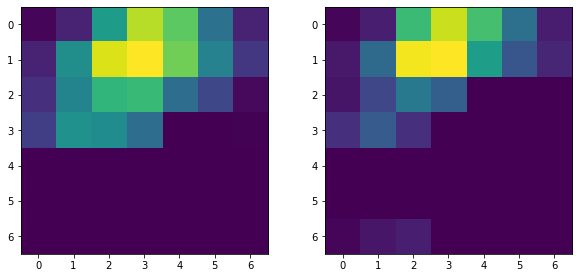

In [57]:
%matplotlib inline

plt.figure(figsize=(10,10))
for ii, _ in enumerate(range(0,n_frames)):
    plt.subplot(2,2,ii+1)
    plt.imshow(heatmap[ii])
#     plt.title(idx_to_label_dict[label.item()])

In [58]:
heatmap = heatmap.numpy()

In [35]:
video[0,:,::5].permute(1,0,2,3).shape

torch.Size([2, 3, 112, 112])

time_frame 0 target class: arranging flowers


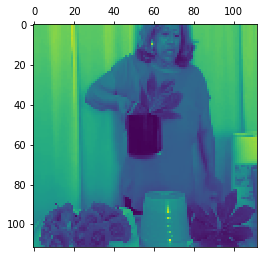

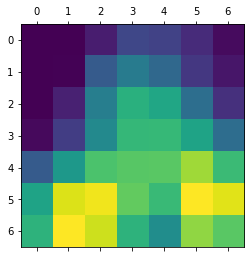

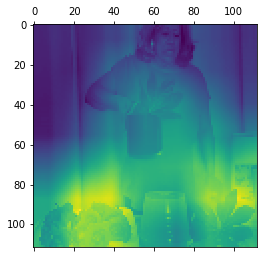

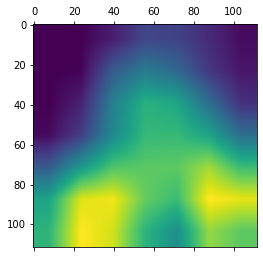

In [332]:
frame_index = np.random.randint(n_frames)
heatmap_f = cv2.resize(heatmap[frame_index], (video.shape[-1], video.shape[-2]))
heatmap_f = np.uint8(255 * heatmap_f)
plt.matshow(heatmap_[frame_index].squeeze())
plt.savefig(str(c)+':h_1.png')
plt.matshow(heatmap[frame_index].squeeze())
# plt.savefig(str(c)+'h_2.png')
plt.matshow(heatmap_f.squeeze()*0.04+heatmap_[5*frame_index].squeeze())
plt.savefig(str(c)+'h_3.png')
plt.matshow(heatmap_f.squeeze())
# plt.savefig(result_path+str(c)+'h_4.png')
print('time_frame',frame_index,'target class:', classes_dict[target])

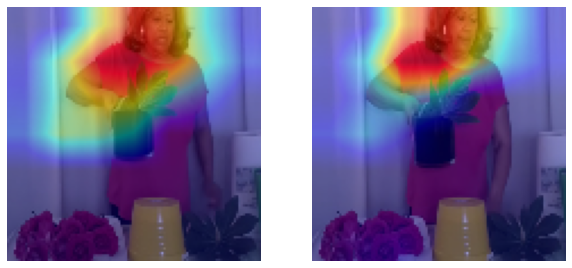

In [59]:
import cv2
import matplotlib
import myutils
from torchvision.transforms.functional import to_pil_image
imgs = video[0,:,::5].permute(1,0,2,3)
# label = yb[0]
%matplotlib inline

plt.figure(figsize=(10,10))
# x = 0.004
for ii,img in enumerate(imgs):
    img_ = np.array(myutils.denormalize(imgs[ii], mean, std))
    plt.subplot(1,2,ii+1)
    heatmap_ = cv2.resize(heatmap[ii], (img_.shape[1], img_.shape[0]))
    heatmap_ = np.uint8(255 * (1-heatmap_))
    heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_ * 0.8 + img_
    superimposed_img = superimposed_img/np.max(superimposed_img)
#     cv2.imwrite('./map.jpg', superimposed_img)
    plt.axis('off')
    plt.imshow(superimposed_img)
#     plt.title(idx_to_label_dict[label.item()])
#     plt.colorbar()
# plt.imshow(myutils.denormalize(imgs[ii], mean, std))
plt.savefig('./ADL_results/3DCNN_1_hair_.png')

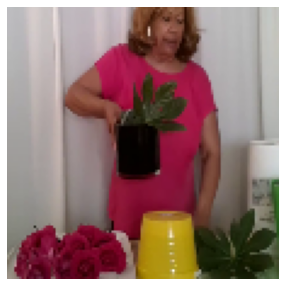

In [60]:
plt.figure(figsize=(5,5))
plt.imshow(myutils.denormalize(imgs[ii], mean, std))
x =plt.axis('off')
plt.savefig('./ADL_results/3DCNN_1_Orig_.png')

In [189]:
torch.max(video), torch.min(video)

(tensor(2.8736, device='cuda:0'), tensor(-1.7822, device='cuda:0'))

In [190]:
orig.shape

(112, 112, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 (2, 7, 7)


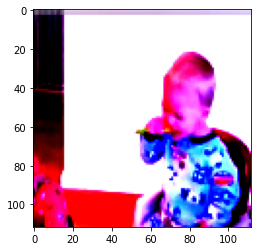

In [191]:
import cv2
# img = cv2.imread('./data/Elephant/data/05fig34.jpg')
# frame_index = np.random.randint(n_frames)
print(frame_index, heatmap.shape)
heatmap_ = cv2.resize(heatmap[frame_index], (video.shape[-1], video.shape[-2]))
# heatmapshow = cv2.normalize(heatmap_, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
# heatmap_ = np.uint8(255 * heatmap_)
# heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
heatmap_ = cv2.applyColorMap(np.uint8(255 * (255 - heatmap_)), cv2.COLORMAP_JET)
superimposed_img = heatmap_ * 0.003 + orig
cv2.imwrite('./map.jpg', superimposed_img)
import matplotlib.image as mpimg
# img = mpimg.imread('./map.jpg')
plt.imshow(orig)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


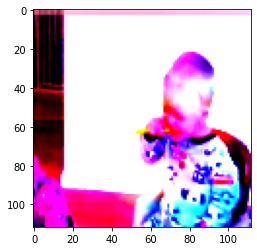

In [192]:
plt.imshow(superimposed_img)
plt.show()

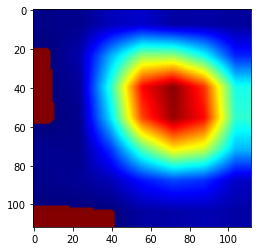

In [182]:
plt.imshow(heatmap_)
plt.legend
plt.show()

In [ ]:
# with torch.no_grad():
for video, target in data_loader: #metric_logger.log_every(data_loader, 100, header):
    video = video.to(device, non_blocking=True)
    target = target.to(device, non_blocking=True)
    output = model(video)
    print(output.requires_grad)
    intermediate_1 = model_shit_1(video)
    print(intermediate_1.shape)
    intermediate_2 = model_shit_2(intermediate_1)
#     output[0,0].backward()
    break
    loss = criterion(output, target)
    loss.backward()
    print(loss.requires_grad)
    print(video.shape)
    break
    acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
    # FIXME need to take into account that the datasets
    # could have been padded in distributed setup
    batch_size = video.shape[0]
    metric_logger.update(loss=loss.item())
    metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
    metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)

In [ ]:
print(intermediate_2.shape)
for i in range(3):
    intermediate_2=intermediate_2.squeeze(-1)
print(intermediate_2.shape)

In [ ]:
print(torch.argmax(output,dim=1), target)
print(loss)

In [ ]:
model

# # time for Grad-CAM and Shit

In [ ]:
intermediate.shape

In [ ]:
i = np.random.randint(10)
j = np.random.randint(512)
src = intermediate[0,j,i,:,:].detach().cpu().numpy()

In [ ]:
print(src.shape)

In [ ]:
src.shape

In [ ]:
import cv2
stretch_near = cv2.resize(src, (100, 100),  
               interpolation = cv2.INTER_NEAREST)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(stretch_near)

In [ ]:

for i in range(5):
        rows, cols, _channels = map(int, src.shape)
        
        #cv.imshow('Pyramids Demo', src)
        src = cv.pyrUp(src, dstsize=(2 * cols, 2 * rows))
        print ('** Zoom In: Image x 2')
            
cv.destroyAllWindows()

In [ ]:
src.shape

In [ ]:
model